In [ ]:
# default_exp plot

# Functions

> A pedigree visualization tool based on dot format and visualized by graphviz 

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# hide
from nbdev import nbdev_export
nbdev_export()

In [ ]:
# export
import yaml
import numpy as np
import pandas as pd
from graphviz import Digraph
from IPython import display

In [ ]:
# export
def load_attributes(yaml_file):
    "Load the self-defined attributes from a yaml file"
    with open(yaml_file, "r") as stream:
        try:
            yml = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return yml

### test `load_attributes`

In [ ]:
attrs=load_attributes('data/default.yaml')

In [ ]:
attrs

{'trait1': {'fillcolor': {1: 'white', 2: 'dimgrey', -9: 'aquamarine3'}},
 'trait2': {'style': {True: 'filled,setlinewidth(4)', False: 'filled'}},
 'trait3': {'fontcolor': {True: 'darkorange', False: 'black'}}}

In [ ]:
# export
def readped(file,attrs=None):
    ''' the number of traits in the input file should match with the number of traits in the attribute yaml file'''
    if attrs:
        peds = pd.read_csv(file,header=None,names=['fid','iid','fathid','mothid','sex']+list(attrs.keys()),sep='\t')
    else:
        peds = pd.read_csv(file,header=None,names=['fid','iid','fathid','mothid','sex','trait'],sep='\t')
    return peds

### test `readped`

In [ ]:
fam=readped('data/example_fam.ped')
fam

,fid,iid,fathid,mothid,sex,trait
0,Fam,F4,P3,F1,1,1
1,Fam,F3,P3,F1,2,1
2,Fam,F2,P3,F1,2,1
3,Fam,F1,P1,P2,2,2
4,Fam,P3,0,0,1,2
5,Fam,P1,0,0,1,-9
6,Fam,P2,0,0,2,-9


In [ ]:
attrs=load_attributes('data/default.yaml')
famext=readped('data/example_fam_ext.ped',attrs)
famext

,fid,iid,fathid,mothid,sex,trait1,trait2,trait3
0,Fam1,F4,P3,F1,1,1,True,False
1,Fam1,F3,P3,F1,2,1,True,True
2,Fam1,F2,P3,F1,2,1,True,False
3,Fam1,F1,P1,P2,2,2,True,False
4,Fam1,P3,0,0,1,2,True,False
5,Fam1,P1,0,0,1,-9,False,True
6,Fam1,P2,0,0,2,-9,False,True


In [ ]:
# export
def update_attributes(r,attrs=None):
    "Assign each node specific attributes"
    #The basic attributes of a node
    attributes={'shape':'polygon','height':'0.3','width':'0.5','regular':'0','style':"filled",'fontcolor':'black'}
    gender = {"m":"box","1":"box",1:"box","f":"ellipse","2":"ellipse",2:"ellipse",0:"polygon"}
    if attrs:
        attributes['shape'] = gender[r.sex]
        for k,v in r[5:].items(): #start from gender to traits
            attr=attrs[k]
            for a,t in attr.items():
                attributes[a] = t[v]
    else:
        trait = {1:'white',2:'dimgrey',-9:'aquamarine3'}
        vcf = {True:"filled,setlinewidth(4)",False:"filled"}
        trim = {True:'darkorange',False:'black'}
        attributes['shape'] = gender[r.sex]
        #traits
        attributes['fillcolor']=trait[r.trait]
        try:
            attributes['style']=vcf[r.vcf]
            attributes['fontcolor'] = trim[r.trim]
        except:
            pass
    return attributes

In [ ]:
# export
def plotped(fi,attrs=None,output=None,format='svg',engine='dot'):
    "The core function of pedigree drawing"
    #nodes
    #create iid nodes
    #create parent nodes
    #edges
    #parent to iid
    #fathid,mothid to parent
    # Create Digraph object
    dot = Digraph()
    dot.engine = engine
    # Add nodes
    parents = []
    for i,r in fi.iterrows():
        dot.node(r.iid,shape='box',_attributes=update_attributes(r,attrs))
        if r.fathid !='0' and r.mothid !='0':
            parents.append(r.fathid+'x'+r.mothid)
            dot.edge(r.fathid+'x'+r.mothid,r.iid)
        #edge to children
        ch_r = (fi.fathid==r.iid) | (fi.mothid==r.iid)
        if ch_r.any():
            for p in fi[ch_r][['fathid','mothid']].agg('x'.join, axis=1).unique():
                dot.edge(r.iid,p)
    for p in set(parents):
        dot.node(p,shape='diamond',label='',height='.1',width='.1')
    if output:
        dot.render(outfile=output+'/'+str(list(fi.fid)[0])+'.'+format,format=format,overwrite_source=True)
    else:
        return dot

### test `plotped`

In [ ]:
dot = Digraph()

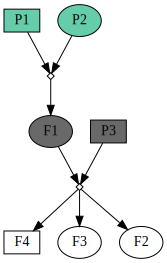

In [ ]:
a=plotped(fam)
a

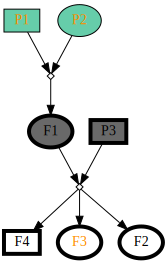

In [ ]:
plotped(famext,attrs)

In [ ]:
# export
def get_args():
    "The arguments of graphped"
    import argparse
    parser = argparse.ArgumentParser(description="The arguments of graphped",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("-p", "--ped", help="a ped file or an extended ped file")
    parser.add_argument("-o", "--output", default='./',help="output folder")
    parser.add_argument("-f", "--format", default='svg', help="the format of the output picture")
    parser.add_argument("-a", "--attributes", help="the attributes of the output picture")
    parser.add_argument("-e", "--engine", default='dot', help="the engine of graphviz rendering the output picture")
    return parser

### test `get_args`

In [ ]:
args = get_args().parse_args('-p data/fam.ped -f svg'.split())

In [ ]:
args

Namespace(ped='data/fam.ped', output='./', format='svg', attributes=None, engine='dot')

In [ ]:
# export
def GraphPedCli():
    "The command line function of GraphPed"
    #test command line
    #args = get_args().parse_args('-p data/fam.ped -f svg'.split())
    args = get_args().parse_args()
    if args.attributes:
        attrs=load_attributes(args.attributes)
    else:
        attrs=None
    ped=readped(args.ped,attrs)
    GraphPed(ped,attrs,args.output,args.format,args.engine)
    

In [ ]:
# export
def GraphPed(ped,attrs=None,output=None,format='svg',engine='dot'):
    "Draw pedigree plot from ped"
    fids=ped.fid.unique()
    dots=[]
    for i in fids:
        dots.append(plotped(ped[ped.fid ==i],attrs,output,format,engine))
    if output is None:
        return dots

### test `GraphPed`

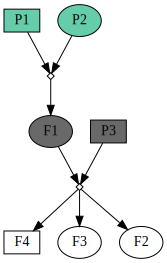

In [ ]:
dots=GraphPed(fam)
dots[0]

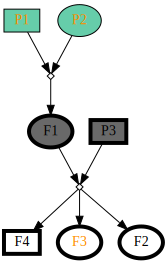

In [ ]:
GraphPed(famext,attrs)[0]

In [ ]:
# export
def show(dot):
    "Plot a pedigree of a list of pedigrees in Jupyter Notebook"
    if isinstance(dot,list):
        for d in dot:
            display.display(d)
    else:
        display.display(dot)

### test `show`

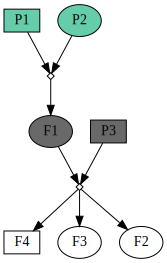

In [ ]:
show(dots)